## STEP 1. 데이터셋 구성

In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


In [2]:
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


In [22]:
image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 4
max_epochs = 10

def _process_pathnames(fname, label_path):
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

## STEP 2. pretrained model을 활용한 U-Net 모델 구성

In [31]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def conv_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(num_filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_light_unet(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder: EfficientNetB0
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)

    skips = [
        base_model.get_layer('block2a_expand_activation').output,
        base_model.get_layer('block3a_expand_activation').output,
        base_model.get_layer('block4a_expand_activation').output,
        base_model.get_layer('block6a_expand_activation').output,
    ]

    encoder_output = base_model.output

    # Decoder (가볍게: 필터 수 줄임)
    x = decoder_block(encoder_output, skips[3], 256)
    x = decoder_block(x, skips[2], 128)
    x = decoder_block(x, skips[1], 64)
    x = decoder_block(x, skips[0], 32)

    ## 마지막 업샘플 추가
    x = layers.Conv2DTranspose(16, (2, 2), strides=2, padding='same')(x)
    x = conv_block(x, 16)

    outputs = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model


In [32]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K

DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

checkpoint_path = os.path.join(DATASET_PATH, 'best_unet_model.h5')

model = build_light_unet(input_shape=(256, 256, 3))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=lambda y_true, y_pred: tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred),
    metrics=[tf.keras.metrics.MeanIoU(num_classes=2)]
)

checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_mean_io_u_8',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop_cb = EarlyStopping(
    monitor='val_mean_io_u_8',
    patience=5,
    mode='max',
    restore_best_weights=True,
    verbose=1
)


16719872/16705208 [==============================] - 0s 0us/step


In [33]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30,
    steps_per_epoch=len(x_train_filenames) // batch_size,
    validation_steps=len(x_test_filenames) // batch_size,
    callbacks=[checkpoint_cb, early_stop_cb]
)


Epoch 1/30
60/60 [==============================] - 20s 135ms/step - loss: 1.4094 - mean_io_u_8: 0.4752 - val_loss: 1.5713 - val_mean_io_u_8: 0.4737

Epoch 00001: val_mean_io_u_8 improved from -inf to 0.47373, saving model to /aiffel/aiffel/medical/best_unet_model.h5
Epoch 2/30
60/60 [==============================] - 8s 109ms/step - loss: 1.2037 - mean_io_u_8: 0.4752 - val_loss: 1.5029 - val_mean_io_u_8: 0.4737

Epoch 00002: val_mean_io_u_8 did not improve from 0.47373
Epoch 3/30
60/60 [==============================] - 8s 109ms/step - loss: 1.0151 - mean_io_u_8: 0.4753 - val_loss: 1.4245 - val_mean_io_u_8: 0.4737

Epoch 00003: val_mean_io_u_8 did not improve from 0.47373
Epoch 4/30
60/60 [==============================] - 8s 107ms/step - loss: 0.9239 - mean_io_u_8: 0.4752 - val_loss: 1.3730 - val_mean_io_u_8: 0.4737

Epoch 00004: val_mean_io_u_8 did not improve from 0.47373
Epoch 5/30
60/60 [==============================] - 8s 109ms/step - loss: 0.8657 - mean_io_u_8: 0.4754 - val_lo

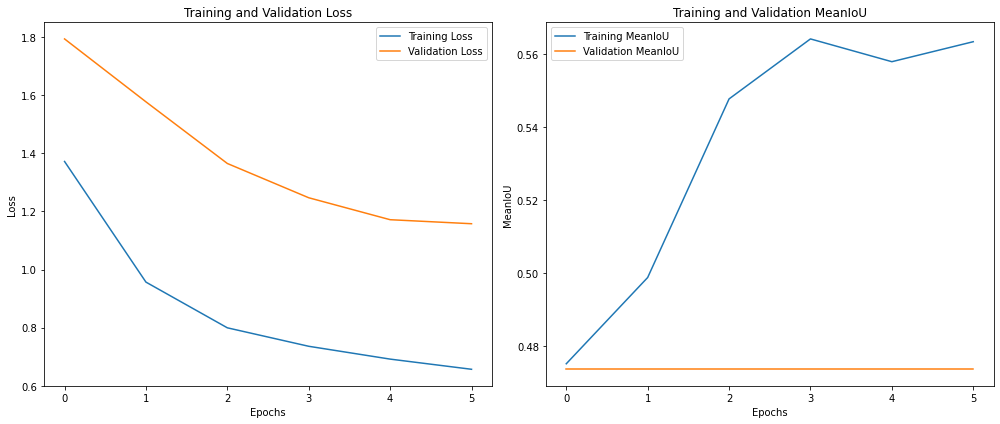

In [30]:
def plot_training_history(history):
    acc = history.history.get('mean_io_u_7', history.history.get('mean_iou'))
    val_acc = history.history.get('val_mean_io_u_7', history.history.get('val_mean_iou'))

    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    epochs_range = range(len(loss))

    plt.figure(figsize=(14, 6))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    if loss and val_loss:
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    # MeanIoU 그래프
    plt.subplot(1, 2, 2)
    if acc and val_acc:
        plt.plot(epochs_range, acc, label='Training MeanIoU')
        plt.plot(epochs_range, val_acc, label='Validation MeanIoU')
        plt.title('Training and Validation MeanIoU')
        plt.xlabel('Epochs')
        plt.ylabel('MeanIoU')
        plt.legend()

    plt.tight_layout()
    plt.show()

# 학습 결과 보기
plot_training_history(history)


결론 : 지각으로 인해 늦게 시작해서 성능을 올리지 못하고 끝났습니다..